## **Модуль ML-7. Прогнозирование биологического ответа (HW-3)**
### ***Итоговое задание***: 

---

#### **1. Описание задачи:**  
Наша практика будет основана на соревновании Kaggle: Predicting a Biological Response (Прогнозирование биологического ответа).

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776). 

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

- Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
- Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import warnings
warnings.filterwarnings('ignore')

#### **2. Знакомство с данными и их исследование:**

In [2]:
# Загружаем исходные данные:
data = pd.read_csv('data/train_sem09.csv')
# Выводим на экран данные:
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Проверяем наличие пропусков:
data.isnull().sum()
data.describe()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,...,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.542255,0.076948,0.592436,0.068142,0.038990,0.212112,0.686653,0.274713,0.455133,0.749517,...,0.026926,0.014663,0.013863,0.021861,0.015196,0.016796,0.012263,0.011730,0.020261,0.011197
std,0.498278,0.079989,0.105860,0.078414,0.115885,0.102592,0.078702,0.090017,0.162731,0.071702,...,0.161889,0.120215,0.116938,0.146249,0.122348,0.128522,0.110074,0.107683,0.140911,0.105236
min,0.000000,0.000000,0.282128,0.000000,0.000000,0.002630,0.137873,0.006130,0.000000,0.275590,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.033300,0.517811,0.000000,0.000000,0.138118,0.625627,0.207374,0.378062,0.707339,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.066700,0.585989,0.050000,0.000000,0.190926,0.674037,0.277845,0.499942,0.738961,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.100000,0.668395,0.100000,0.000000,0.261726,0.740663,0.335816,0.569962,0.788177,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,0.964381,0.950000,1.000000,1.000000,0.994735,0.790831,0.989870,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
# Создаем матрицу наблюдений X и вектор ответов y:

X = data.drop(['Activity'], axis=1)
y = data['Activity']

# Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
# Для сохранения соотношений целевого признака используем
# параметр stratify (стратифицированное разбиение). 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, random_state = 1, test_size = 0.2)

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (3000, 1776)
Test shape: (751, 1776)


In [5]:
# Смотрим на сбалансированность классов:

print('Train :')
display(y_train.value_counts(normalize = True))

print('Test :', )
display(y_test.value_counts(normalize =  True))

Train :


Activity
1    0.542333
0    0.457667
Name: proportion, dtype: float64

Test :


Activity
1    0.541944
0    0.458056
Name: proportion, dtype: float64

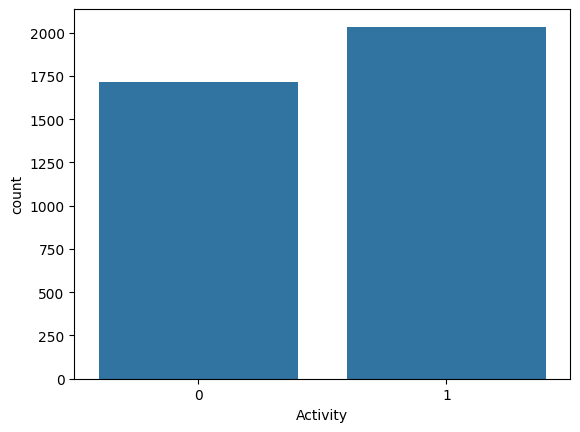

In [6]:
sns.countplot(data = data, x = 'Activity');

### **3. Оптимизация гиперпараметров модели:**

#### **Логистическая регрессия:**

In [7]:
# Создаем объект класса логистическая регрессия:
log_reg = linear_model.LogisticRegression(max_iter = 50)

# Обучаем модель, минимизируя logloss:
log_reg.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = log_reg.predict(X_train)

# Делаем предсказание для тестовой выборки:
y_test_pred = log_reg.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(log_reg.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79


**1. GridSearchCV():**

In [8]:
# Теперь зададим сетку гиперпараметров и посчитаем GridSearchCV():

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
  
%time grid_search.fit(X_train, y_train) 

print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))

y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 5.52 s
Wall time: 15.1 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


In [9]:
# Попробуем расширить сетку гиперпараметров:

param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 4.11 s
Wall time: 3min 4s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [10]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=50, random_state=42, solver='saga')


In [11]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


In [12]:
# Результаты кросс-валидации:
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.366815,0.053217,0.038777,0.012214,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.738333,0.763333,0.780000,0.745,0.746667,0.754667,0.015107,22
1,5.670130,0.119149,0.041776,0.017338,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.738333,0.763333,0.781667,0.745,0.745000,0.754667,0.015861,21


In [13]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

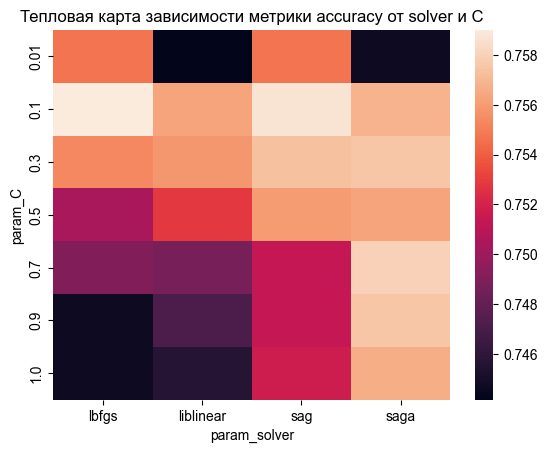

In [14]:
# Точность при различных гиперпараметрах:
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С')
sns.set(rc={'figure.figsize':(12, 8)})

**2. RandomizedSearchCV():**

In [15]:
# Теперь зададим сетку гиперпараметров и посчитаем RandomizedSearchCV():

param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 

print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))

y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: total: 2.03 s
Wall time: 5.14 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.45}


#### **Случайный лес:**

In [16]:
# Создаем объект класса случайный лес:
rf = ensemble.RandomForestClassifier(random_state = 42)

# Обучаем модель:
rf.fit(X_train, y_train)

# Делаем предсказание для тренировочной выборки:
y_train_pred = rf.predict(X_train)

# Делаем предсказание для тестовой выборки:
y_test_pred = rf.predict(X_test)

print("accuracy на тестовом наборе: {:.2f}".format(rf.score(X_test, y_test)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


**1. GridSearchCV():**

In [17]:
# Теперь зададим сетку гиперпараметров и посчитаем GridSearchCV():

param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 

y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))

y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 2.86 s
Wall time: 55.1 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


**2. RandomizedSearchCV():**

In [18]:
# Теперь зададим сетку гиперпараметров и посчитаем RandomizedSearchCV():

param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 

y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))

y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 2.42 s
Wall time: 28.4 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 20}


**Вывод:** RandomizedSearchCV демонстрирует более эффективную и быструю работу чем GridSearchCV.

**3. Hyperot:**

In [19]:
# зададим пространство поиска гиперпараметров:
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

# зафиксируем random_state:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели:
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель:
    model.fit(X_train, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус:
    return -score

In [20]:
%%time

# начинаем подбор гиперпараметров:

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
          space = space, # пространство гиперпараметров
          algo = tpe.suggest, # алгоритм оптимизации
          max_evals = 20, # максимальное количество итераций
          trials = trials # логирование результатов
         )
print("Наилучшие значения гиперпараметров {}".format(best))

# рассчитаем точность для тестовой выборки:
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

100%|██████████| 20/20 [00:46<00:00,  2.32s/trial, best loss: -0.9920294297976702]
Наилучшие значения гиперпараметров {'max_depth': 25.0, 'min_samples_leaf': 2.0, 'n_estimators': 143.0}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
CPU times: total: 49.1 s
Wall time: 49.3 s


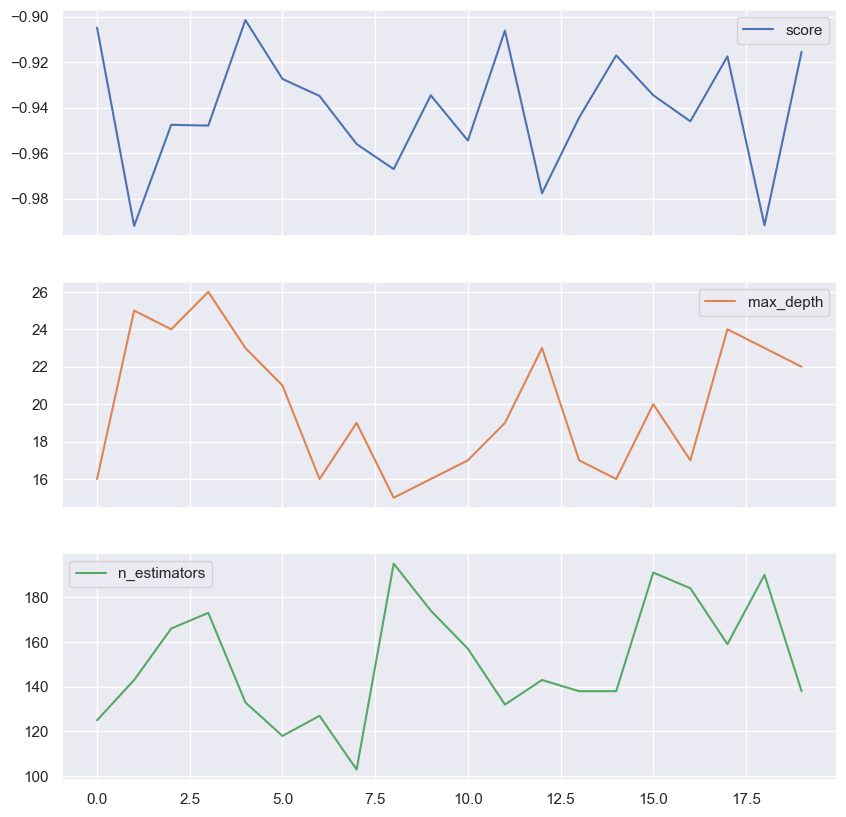

In [21]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

**Вывод:** Hyperot смог улучшить нашу метрику, причем за меньшее время.

**4. Optuna:**

In [22]:
def optuna_rf(trial):
    
  # задаем пространства поиска гиперпараметров:
  
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель:
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  # обучаем модель:
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score

In [23]:
%%time

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки:
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2025-04-29 23:56:38,598] A new study created in memory with name: RandomForestClassifier
[I 2025-04-29 23:56:39,981] Trial 0 finished with value: 0.9042520648516366 and parameters: {'n_estimators': 104, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9042520648516366.
[I 2025-04-29 23:56:41,902] Trial 1 finished with value: 0.9285714285714286 and parameters: {'n_estimators': 121, 'max_depth': 22, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9285714285714286.
[I 2025-04-29 23:56:44,772] Trial 2 finished with value: 0.9577205882352942 and parameters: {'n_estimators': 171, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9577205882352942.
[I 2025-04-29 23:56:47,623] Trial 3 finished with value: 0.9752369306022624 and parameters: {'n_estimators': 157, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9752369306022624.
[I 2025-04-29 23:56:49,844] Trial 4 finished with value: 0.9453768690875801 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 185, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
CPU times: total: 57.2 s
Wall time: 57.6 s


In [24]:
%%time

# можем прододжить подбор, указав n_trials
# (любое число, которое добавится к предыдущим итерациям) 

study.optimize(optuna_rf, n_trials=10)

[I 2025-04-29 23:57:39,294] Trial 20 finished with value: 0.9583843329253366 and parameters: {'n_estimators': 179, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 14 with value: 0.9929555895865237.
[I 2025-04-29 23:57:42,478] Trial 21 finished with value: 0.992651561543172 and parameters: {'n_estimators': 166, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9929555895865237.
[I 2025-04-29 23:57:46,003] Trial 22 finished with value: 0.992651561543172 and parameters: {'n_estimators': 190, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 14 with value: 0.9929555895865237.
[I 2025-04-29 23:57:49,071] Trial 23 finished with value: 0.9776690119302539 and parameters: {'n_estimators': 174, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 14 with value: 0.9929555895865237.
[I 2025-04-29 23:57:52,133] Trial 24 finished with value: 0.9920391916717698 and parameters: {'n_estimators': 160, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 14 with valu

CPU times: total: 30.5 s
Wall time: 30.6 s


**Вывод:** Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.

In [25]:
# Построим график:

optuna.visualization.plot_optimization_history(study, target_name="f1_score")

**Итоговый вывод:** проведено обучение двух моделей - логистическая регрессия и случайный лес, сделан подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Использовано четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna). Наилучший результат показал - Optuna.